- https://github.com/heykeetae/Self-Attention-GAN/blob/master/sagan_models.py
- https://github.com/heykeetae/Self-Attention-GAN
- https://towardsdatascience.com/building-your-own-self-attention-gans-e8c9b9fe8e51
- https://arxiv.org/pdf/1802.05957.pdf

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torchvision
%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
import util.plot as plot
import util.download

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 28
tfmnist = T.Compose([
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
#     T.Lambda(lambda x: x.repeat(3, 1, 1)),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,), std=(.5,)),
    
])

mnist_ds = torchvision.datasets.MNIST(DATA_DIR.joinpath('mnist'), download=True, transform=tfmnist)
mnist_dl = torch.utils.data.DataLoader(mnist_ds, batch_size=4, shuffle=True, num_workers=1)

In [3]:
# T.ToPILImage()(mnist_ds[0][0])
# mnist_ds[0]

Found 60000 images in dataset folder.


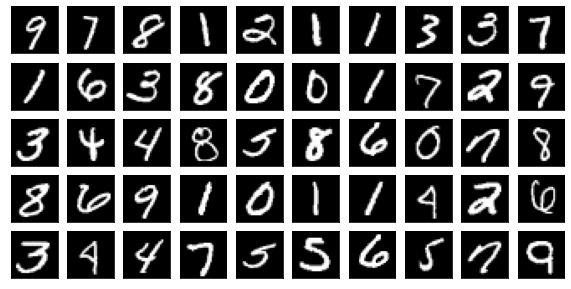

In [4]:
_ = plot.dataset_first_n_gray(mnist_ds, 50, figsize=(10,5), nrows=5)
print(f'Found {len(mnist_ds)} images in dataset folder.')

In [6]:
import sagan as gan

print("### Image size")
x0, y0 = mnist_ds[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

print("#### Discriminator")
dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

print("### Discriminator output shape")
d0, p = dsc(x0)
print(d0.shape, p.shape)

### Image size
torch.Size([1, 1, 28, 28])
#### Discriminator
Discriminator(
  (attn): SelfAttention(
    (query_conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (last): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (feature_extractor): Sequential(
    (0): SpectralNorm(
      (module): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SpectralNorm(
      (module): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    

In [7]:
print("### Generator")
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

print("### Generator output shape")
z = torch.randn(1, z_dim).to(device)
xr, p  = gen(z)
print(xr.shape, p.shape)

### Generator
Generator(
  (attn): SelfAttention(
    (query_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=-1)
  )
  (gen): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(128, 512, kernel_size=(3, 3), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    )
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): SpectralNorm(
      (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()


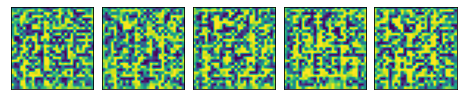

In [8]:
samples = gen.sample(5, with_grad=False)
_ = plot.tensors_as_images(samples.cpu())


In [59]:
from torch.utils.data import Dataset as Dataset
class SubsetDataset(torch.utils.data.Dataset):
    """
    A dataset that wraps another dataset, returning a subset from it.
    """
    def __init__(self, ds: Dataset, subset_len):
        super().__init__()
        self.ds = ds
        self.len = len(self.ds)
        self.subset_len = subset_len

    def __getitem__(self, index):
        idx = torch.randint(low=0,high=self.len, size=(1,))
        return self.ds[idx[0]]

    def __len__(self):
        return self.subset_len

In [60]:
ds = SubsetDataset(mnist_ds, subset_len=5000)

In [62]:
import torch.optim as optim
from torch.utils.data import DataLoader

torch.manual_seed(999)

# Hyperparams
hp = dict(
        batch_size=32, z_dim=100, data_label=1, label_noise=0.2,
        discriminator_optimizer=dict(
            type='Adam', 
            lr=0.0002,
            weight_decay=0.02,
            betas=(0.5, 0.999)
        ),
        generator_optimizer=dict(
            type='Adam',  
            lr=0.0002,
            weight_decay=0.02,
            betas=(0.5, 0.999)
        ),
    )
    

ds = SubsetDataset(mnist_ds, subset_len=5000)
# Data
dl_train = DataLoader(ds, hp['batch_size'], shuffle=True)
im_size = mnist_ds[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# custom weights initialization called on netG and netD
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)
        
def weights_init(m):
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
gen.apply(weights_init)
dsc.apply(weights_init)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)

dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/sagan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 32, 'z_dim': 100, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.02, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'weight_decay': 0.02, 'betas': (0.5, 0.999)}}


--- EPOCH 1/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:05<00:00,  2.40it/s]
Discriminator loss: 0.1561964298746768
Generator loss:     0.8926958820907174


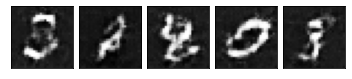

--- EPOCH 2/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.34it/s]
Discriminator loss: 0.1561281510456732
Generator loss:     0.8996350283076049


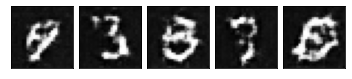

--- EPOCH 3/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.33it/s]
Discriminator loss: 0.1857884403816454
Generator loss:     0.870353418313394


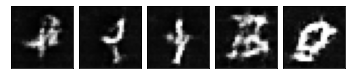

--- EPOCH 4/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:15<00:00,  2.09it/s]
Discriminator loss: 0.21699826746799383
Generator loss:     0.8644232486558568


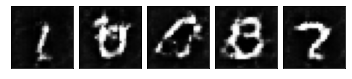

--- EPOCH 5/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.35it/s]
Discriminator loss: 0.21411906794947425
Generator loss:     0.8477876639574956
Saved checkpoint.


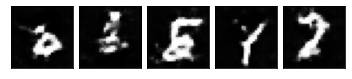

--- EPOCH 6/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.35it/s]
Discriminator loss: 0.2108591379016448
Generator loss:     0.8474004127227577


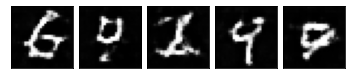

--- EPOCH 7/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.33it/s]
Discriminator loss: 0.25779374973599317
Generator loss:     0.7916498046581912


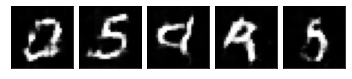

--- EPOCH 8/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.37it/s]
Discriminator loss: 0.22681932170299968
Generator loss:     0.8151807323762565


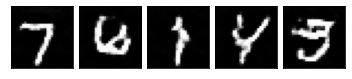

--- EPOCH 9/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.36it/s]
Discriminator loss: 0.24512993772128586
Generator loss:     0.8209233140205122


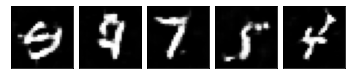

--- EPOCH 10/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.36it/s]
Discriminator loss: 0.20784713408559752
Generator loss:     0.8191125337864943
Saved checkpoint.


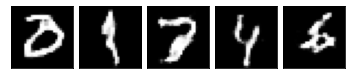

--- EPOCH 11/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.37it/s]
Discriminator loss: 0.23369296886928523
Generator loss:     0.8178991243527953


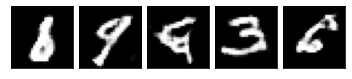

--- EPOCH 12/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:09<00:00,  2.26it/s]
Discriminator loss: 0.22417970860649825
Generator loss:     0.8169472764252098


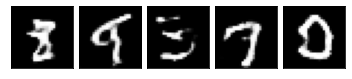

--- EPOCH 13/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.33it/s]
Discriminator loss: 0.23499208033844166
Generator loss:     0.8275314247722079


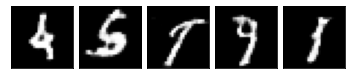

--- EPOCH 14/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.31it/s]
Discriminator loss: 0.22479039031988496
Generator loss:     0.8181376276881831


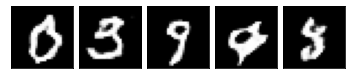

--- EPOCH 15/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.35it/s]
Discriminator loss: 0.21006784094556882
Generator loss:     0.8454431334308757
Saved checkpoint.


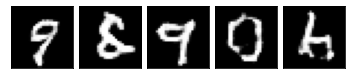

--- EPOCH 16/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:09<00:00,  2.26it/s]
Discriminator loss: 0.21012595243704546
Generator loss:     0.8443950116634369


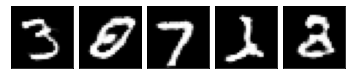

--- EPOCH 17/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:18<00:00,  2.01it/s]
Discriminator loss: 0.24890910359514748
Generator loss:     0.8031545613601709


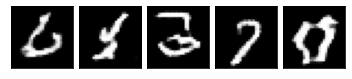

--- EPOCH 18/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:08<00:00,  2.29it/s]
Discriminator loss: 0.2211663134538444
Generator loss:     0.8184883940941209


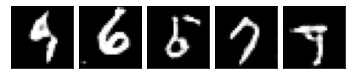

--- EPOCH 19/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.32it/s]
Discriminator loss: 0.22529936339824821
Generator loss:     0.816968616406629


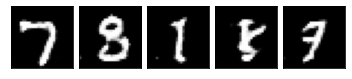

--- EPOCH 20/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.32it/s]
Discriminator loss: 0.225421595250725
Generator loss:     0.8331900332004402
Saved checkpoint.


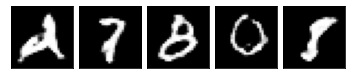

--- EPOCH 21/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.34it/s]
Discriminator loss: 0.2013452090560251
Generator loss:     0.8575500617171549


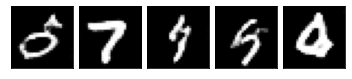

--- EPOCH 22/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.36it/s]
Discriminator loss: 0.2160888464682421
Generator loss:     0.8696708781704022


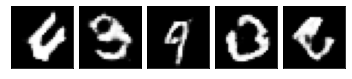

--- EPOCH 23/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.37it/s]
Discriminator loss: 0.23505237480257726
Generator loss:     0.8082667828365496


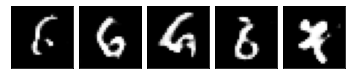

--- EPOCH 24/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.37it/s]
Discriminator loss: 0.2089925045800057
Generator loss:     0.8440991292713554


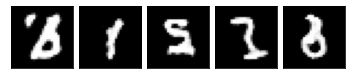

--- EPOCH 25/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.36it/s]
Discriminator loss: 0.21803489118624644
Generator loss:     0.8604951423064918
Saved checkpoint.


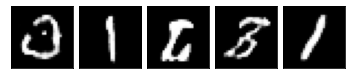

--- EPOCH 26/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.33it/s]
Discriminator loss: 0.23141195572865236
Generator loss:     0.8374323160595195


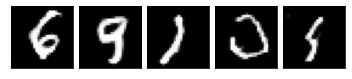

--- EPOCH 27/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.31it/s]
Discriminator loss: 0.21216873891034704
Generator loss:     0.8336395235008495


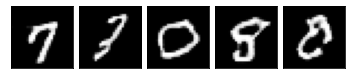

--- EPOCH 28/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.36it/s]
Discriminator loss: 0.20079011474825015
Generator loss:     0.8590143531750721


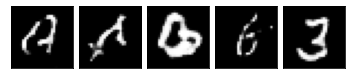

--- EPOCH 29/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.34it/s]
Discriminator loss: 0.21172191136202234
Generator loss:     0.8568095198482465


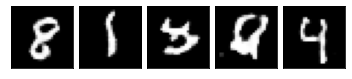

--- EPOCH 30/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.35it/s]
Discriminator loss: 0.19860607262249966
Generator loss:     0.8549689857443427
Saved checkpoint.


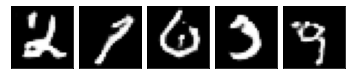

--- EPOCH 31/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:12<00:00,  2.16it/s]
Discriminator loss: 0.21899089596833393
Generator loss:     0.8345809645333867


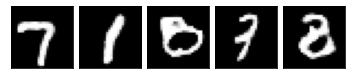

--- EPOCH 32/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.36it/s]
Discriminator loss: 0.20154094178775314
Generator loss:     0.847385061204813


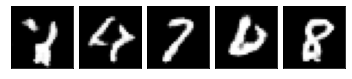

--- EPOCH 33/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.34it/s]
Discriminator loss: 0.1894775977370086
Generator loss:     0.8760989103347633


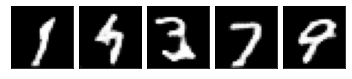

--- EPOCH 34/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.35it/s]
Discriminator loss: 0.1920063359912034
Generator loss:     0.8635381162166595


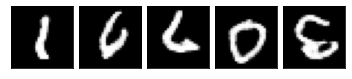

--- EPOCH 35/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.36it/s]
Discriminator loss: 0.20197492439276094
Generator loss:     0.8560860684722852
Saved checkpoint.


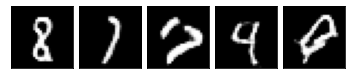

--- EPOCH 36/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.35it/s]
Discriminator loss: 0.18584280850211526
Generator loss:     0.87454652843202


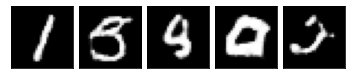

--- EPOCH 37/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.37it/s]
Discriminator loss: 0.1781475999552733
Generator loss:     0.8567832258476573


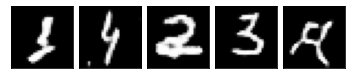

--- EPOCH 38/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.34it/s]
Discriminator loss: 0.20035837581203242
Generator loss:     0.8577670952317061


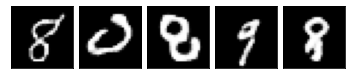

--- EPOCH 39/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.35it/s]
Discriminator loss: 0.20151643630615465
Generator loss:     0.8715229730127724


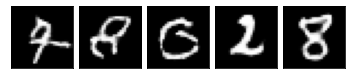

--- EPOCH 40/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.37it/s]
Discriminator loss: 0.2027761968220495
Generator loss:     0.8583008908921745
Saved checkpoint.


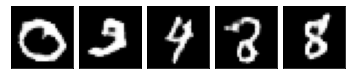

--- EPOCH 41/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.34it/s]
Discriminator loss: 0.2058725537388188
Generator loss:     0.8343081067606901


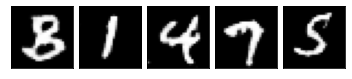

--- EPOCH 42/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.33it/s]
Discriminator loss: 0.198208360535324
Generator loss:     0.8378685002873658


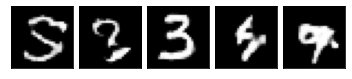

--- EPOCH 43/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:05<00:00,  2.38it/s]
Discriminator loss: 0.18521773895830107
Generator loss:     0.8547734734928532


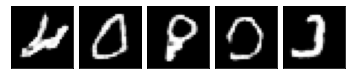

--- EPOCH 44/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:08<00:00,  2.31it/s]
Discriminator loss: 0.21224104411378028
Generator loss:     0.8085923897232979


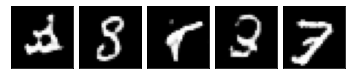

--- EPOCH 45/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.34it/s]
Discriminator loss: 0.20675499001695852
Generator loss:     0.8131683241030213
Saved checkpoint.


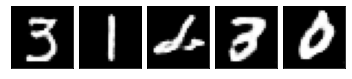

--- EPOCH 46/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.33it/s]
Discriminator loss: 0.19521821570244563
Generator loss:     0.8520423252681258


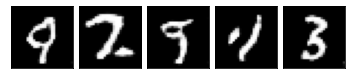

--- EPOCH 47/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:08<00:00,  2.29it/s]
Discriminator loss: 0.19019889836288562
Generator loss:     0.8318061092097289


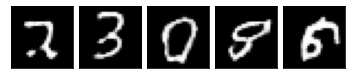

--- EPOCH 48/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:08<00:00,  2.30it/s]
Discriminator loss: 0.16183466613767253
Generator loss:     0.8829473078630532


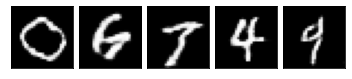

--- EPOCH 49/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:07<00:00,  2.34it/s]
Discriminator loss: 0.20546764994313002
Generator loss:     0.8253202940438203


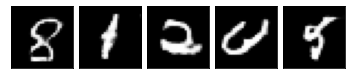

--- EPOCH 50/50 ---
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [01:06<00:00,  2.36it/s]
Discriminator loss: 0.19098461865429667
Generator loss:     0.8235937426234506
Saved checkpoint.


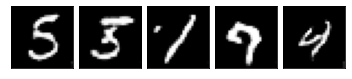

In [73]:
import IPython.display
import tqdm
from sagan import train_batch, save_checkpoint

num_epochs = 50

# if os.path.isfile(f'{checkpoint_file_final}.pt'):
#     print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
#     num_epochs = 0
#     gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
#     checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            
        samples, p = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_gray_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

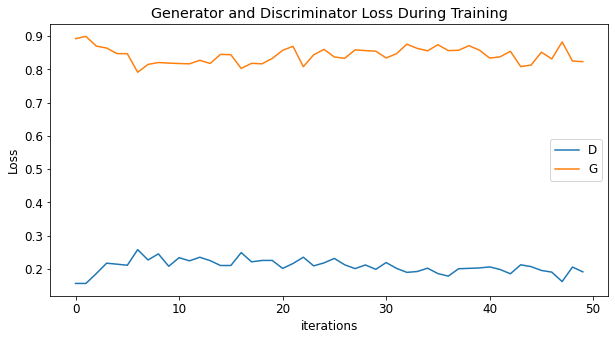

In [75]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(dsc_avg_losses,label="D")
plt.plot(gen_avg_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [79]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)

*** Images Generated from best model:


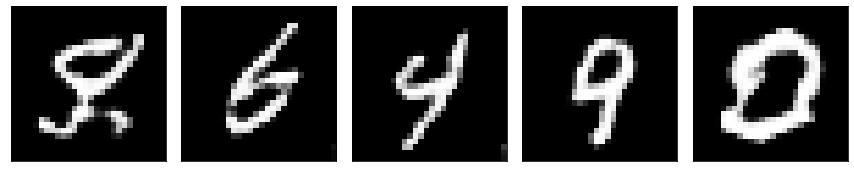

In [96]:
print('*** Images Generated from best model:')
samples, p  = gen.sample(n=5, with_grad=False)
fig, _ = plot.tensors_as_gray_images(samples.cpu(), nrows=1, figsize=(15,15))

In [97]:
p = p.unsqueeze(1)

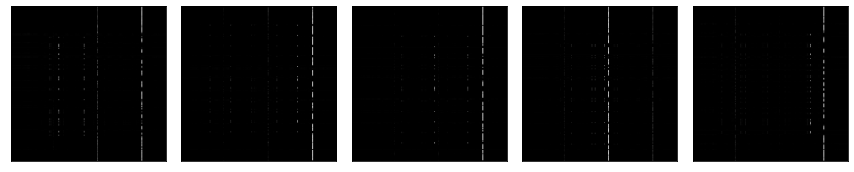

In [98]:
fig, _ = plot.tensors_as_gray_images(p.cpu(), nrows=1, figsize=(15,15))